# Power Data EDA for MIE1628 Cloud Data Analytics Project

In [70]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import random
from datetime import datetime, timedelta

import re
import io
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

## Import data

Import time-series data in loop and append

### Demand 2018-2023

In [155]:
demand = []
for x in range(2018,2024):
    print(x)
    dem_x = pd.read_csv('demand_data_hourly/PUB_Demand_{}.csv'.format(x), header=3, index_col=0)   
    dem_x.index = pd.DatetimeIndex(dem_x.index) + pd.to_timedelta(dem_x['Hour'], unit='h')
    demand.append(dem_x)

demand_t = pd.concat(demand)
print(demand_t.shape)
demand_t.head()

2018
2019
2020
2021
2022
2023
(51576, 3)


,Hour,Market Demand,Ontario Demand
2018-01-01 01:00:00,1,18974,16627
2018-01-01 02:00:00,2,18447,16084
2018-01-01 03:00:00,3,18453,15866
2018-01-01 04:00:00,4,18662,15725
2018-01-01 05:00:00,5,18060,15470


In [ ]:
demand_t[datetime(2021,1,1,0):datetime(2021,1,1,5)]

,Hour,Market Demand,Ontario Demand
2021-01-01 00:00:00,24,16723,14665
2021-01-01 01:00:00,1,16057,14112
2021-01-01 02:00:00,2,15516,13504
2021-01-01 03:00:00,3,15185,13155
2021-01-01 04:00:00,4,14940,12892
2021-01-01 05:00:00,5,14802,12798
2021-01-01 06:00:00,6,14880,12891
2021-01-01 07:00:00,7,14998,13188
2021-01-01 08:00:00,8,15463,13570
2021-01-01 09:00:00,9,15612,13820


<AxesSubplot:ylabel='Market Demand'>

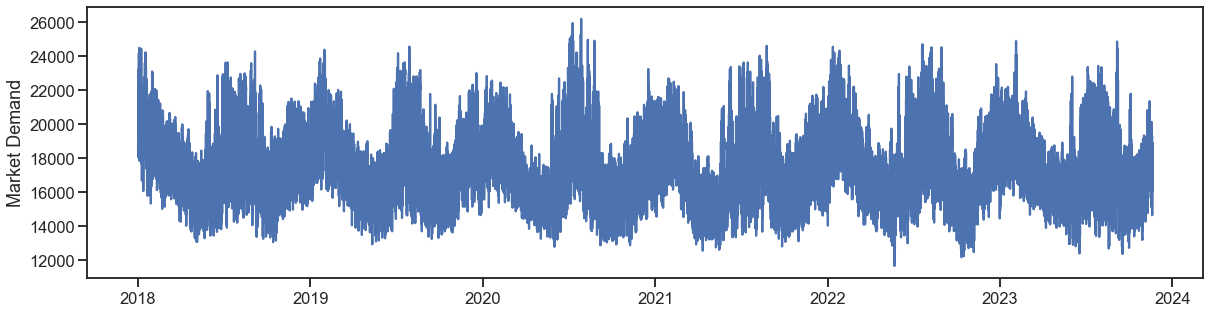

In [64]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=demand_t, y='Market Demand', x=demand_t.index, ax=ax)

In [141]:
# plot every day in 2021
#fig, ax_n = plt.subplots(figsize=(15,8))
year = 2021

def plt_year_dem(year, ax, times_series, y_string, x_string='Hour', color='limegreen', ylim=[0,100], ylab='Demand (MW)', statistic=np.mean):
    dem_range_l = []
    for t in (datetime(year,1,1) + timedelta(n) for n in range(365)):
        dem_range = times_series[t:t+timedelta(hours=23)]
        dem_range_l.append(dem_range)
        sns.lineplot(data=dem_range, y=y_string, x=x_string, ax=ax,
                    alpha=0.6, color='lightgrey')
        
    dem_agg = pd.concat(dem_range_l).groupby(x_string).agg(statistic)
    sns.lineplot(data=dem_agg, y=y_string, x=x_string, ax=ax,
                    alpha=1, color=color, linewidth=3)

    ax.set_title(year)
    ax.set_xlabel('Hour')
    ax.set_ylabel(ylab)
    ax.set_xlim([1,24])
    ax.set_ylim([ylim[0],ylim[1]])

#plt_year_dem(2021, ax_n, demand_t)

2018
2019
2020
2021
2022
2023


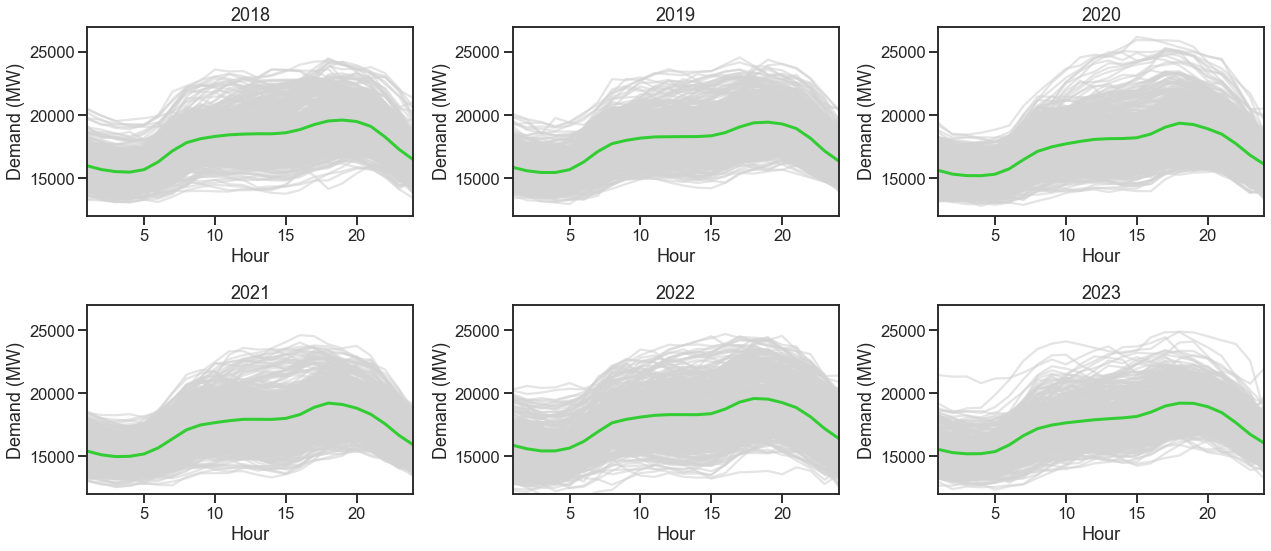

In [136]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, demand_t, 
                 y_string='Market Demand', ylim=[12000, 27000]) 

plt.tight_layout()

### Price (our target probably)

In [154]:
price = []
for x in range(2018,2024):
    print(x)
    
    price_x = pd.read_csv('price_data_y/PUB_PriceHOEPPredispOR_{}.csv'.format(x), header=3, index_col=0)   
    price_x.index = pd.DatetimeIndex(price_x.index) + pd.to_timedelta(price_x['Hour'], unit='h')
    price.append(price_x)

price_t = pd.concat(price)
print(price_t.shape)
price_t.head()

2018
2019
2020
2021
2022
2023
(51576, 8)


,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
2018-01-01 01:00:00,1,51.29,40.62,35.50,40.32,0.20,0.20,0.19
2018-01-01 02:00:00,2,43.59,40.93,40.57,30.22,0.20,0.20,0.20
2018-01-01 03:00:00,3,93.60,49.84,45.30,40.20,0.25,0.25,0.22
2018-01-01 04:00:00,4,54.78,55.60,40.04,45.30,0.20,0.20,0.20
2018-01-01 05:00:00,5,14.35,40.04,34.80,47.47,0.20,0.20,0.20


2018
2019
2020
2021
2022
2023


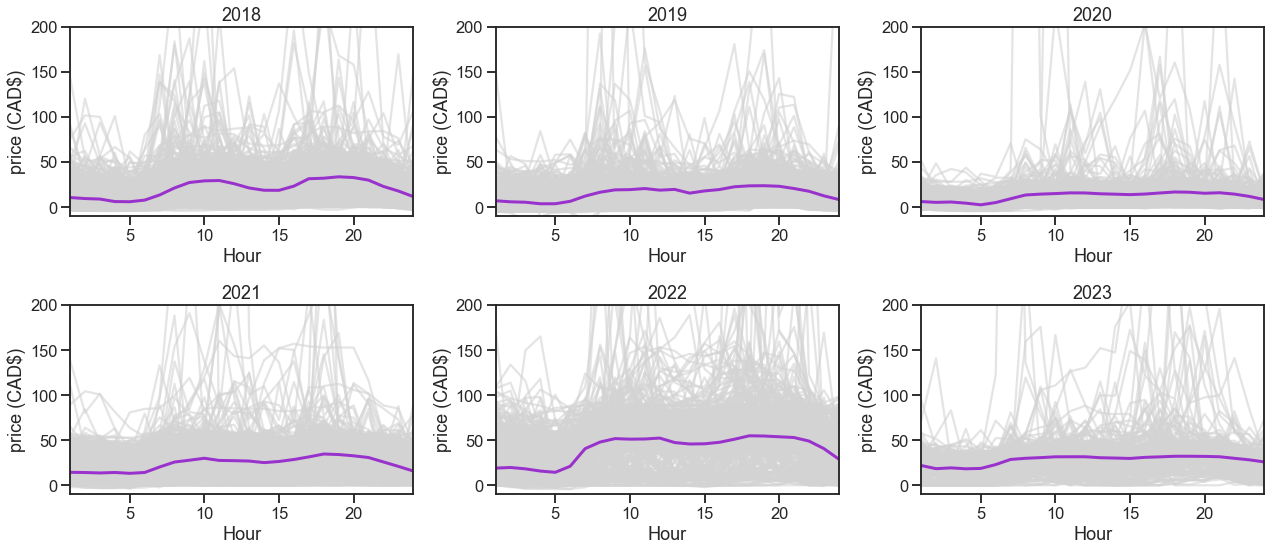

In [143]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, price_t, 
                 y_string='HOEP', ylim=[-10, 200], ylab='price (CAD$)', color='darkorchid', statistic=np.median) 

plt.tight_layout()

### Grid inflow outflow data

In [153]:
flow = []
for x in range(2018,2024):
    print(x)
    flow_x = pd.read_csv('flow_data/PUB_IntertieScheduleFlowYear_{}.csv'.format(x), header=4, index_col=0)   
    flow_x.index = pd.DatetimeIndex(flow_x.index) + pd.to_timedelta(flow_x['Hour'], unit='h')
    flow.append(flow_x)

flow_t = pd.concat(flow)
print(flow_t.shape)
flow_t.head()

2018
2019
2020
2021
2022
2023
(51576, 46)


,Hour,Imp,Exp,Flow,Imp.1,Exp.1,Flow.1,Imp.2,Exp.2,Flow.2,...,Flow.11,Imp.12,Exp.12,Flow.12,Imp.13,Exp.13,Flow.13,Imp.14,Exp.14,Flow.14
2018-01-01 01:00:00,1,28,42,16,0,0,8,0,900,377,...,0,0,0,69,50,0,-46,376,2394,2144
2018-01-01 02:00:00,2,28,0,-20,0,0,8,0,900,379,...,0,0,0,68,50,0,-45,242,2402,2255
2018-01-01 03:00:00,3,28,0,-26,0,0,8,0,900,392,...,0,0,0,46,50,0,-45,92,2599,2580
2018-01-01 04:00:00,4,28,0,-36,0,0,8,0,900,405,...,0,0,0,46,50,0,-45,587,3008,2594
2018-01-01 05:00:00,5,28,42,6,0,0,8,0,426,352,...,0,0,0,46,50,0,-44,265,2630,2505


2018
2019
2020
2021
2022
2023


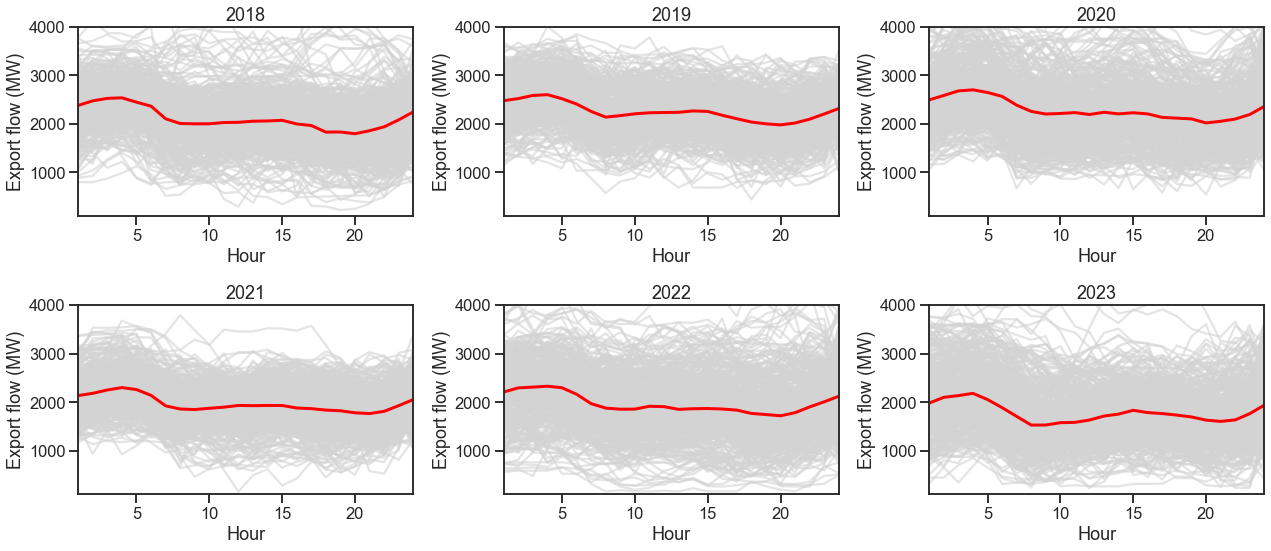

In [157]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, flow_t, 
                 y_string='Exp.14', ylim=[100, 4000], ylab='Export flow (MW)', color='red', statistic=np.median) 

plt.tight_layout()

2018
2019
2020
2021
2022
2023


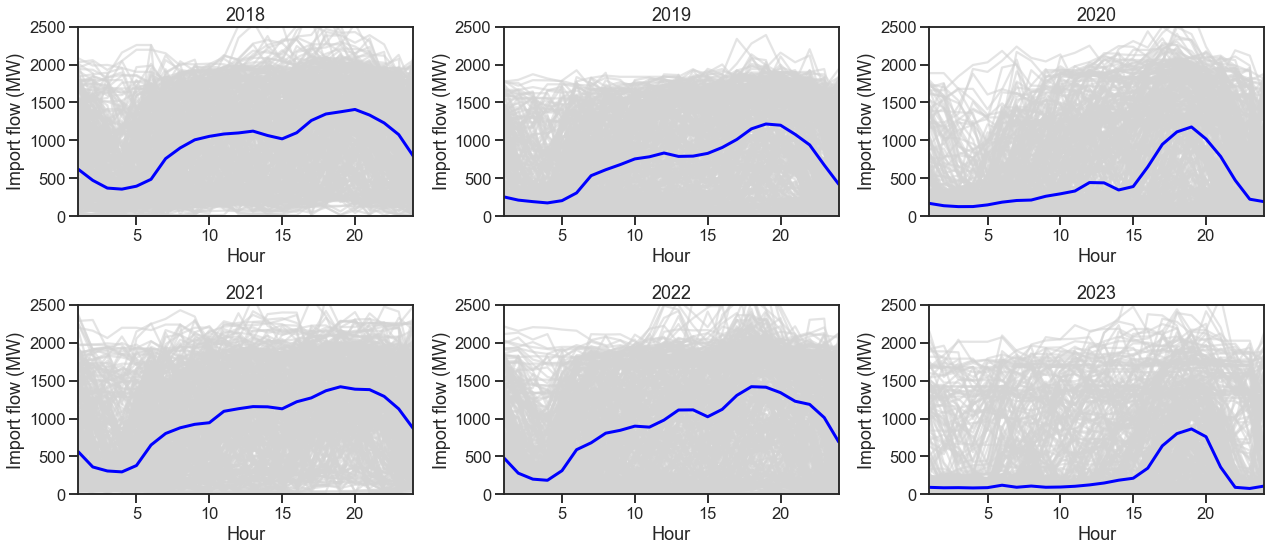

In [159]:
fig, ax = plt.subplots(2,3, figsize=(18,8))

for i, axy in enumerate(ax.reshape(-1)):
    print(i+2018)
    plt_year_dem(i+2018, axy, flow_t, 
                 y_string='Imp.14', ylim=[0, 2500], ylab='Import flow (MW)', color='blue', statistic=np.median) 

plt.tight_layout()

Many dimensions; reduce using SVD

In [160]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [171]:
# exclude total columns at end
flow_scaled = StandardScaler().fit_transform(flow_t.iloc[:,:43])
pca = PCA()
flow_pcs = pca.fit_transform(flow_scaled)

# Store
cols= ['pc{}'.format(i) for i in range(1,flow_scaled.shape[1]+1)]
flow_pcs_df = pd.DataFrame(data=flow_pcs,
                            columns=cols)

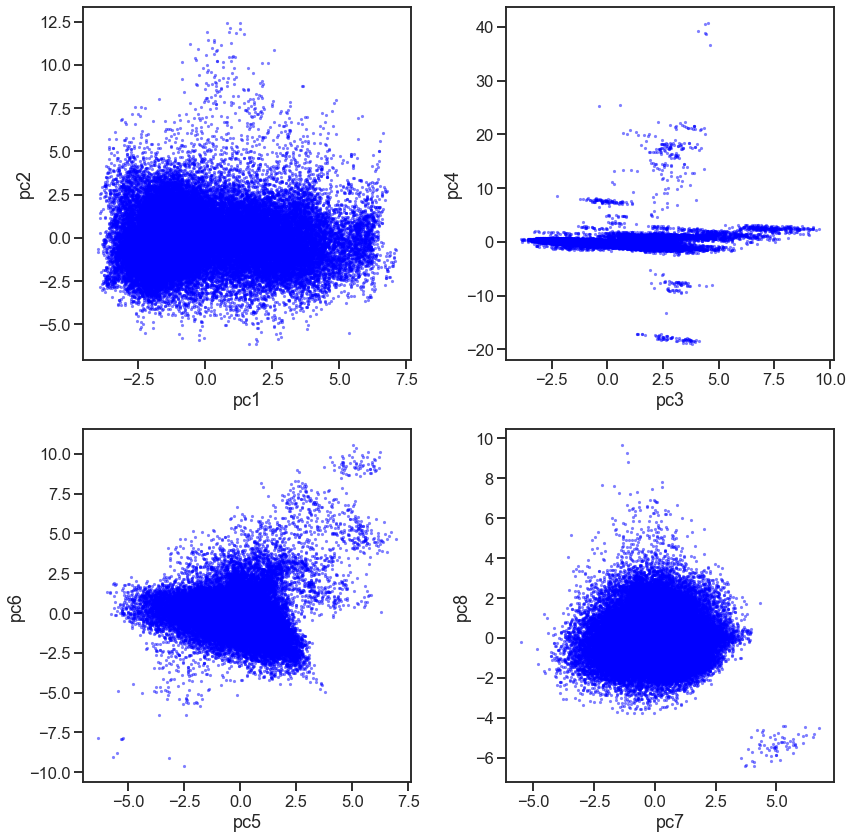

In [202]:
flow_pcs_df
fig, ax = plt.subplots(2,2, figsize=(12,12))
c = 'blue'
sns.scatterplot(ax=ax[0,0], data=flow_pcs_df, x='pc1', y='pc2', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
sns.scatterplot(ax=ax[0,1], data=flow_pcs_df, x='pc3', y='pc4', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
sns.scatterplot(ax=ax[1,0], data=flow_pcs_df, x='pc5', y='pc6', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
sns.scatterplot(ax=ax[1,1], data=flow_pcs_df, x='pc7', y='pc8', 
                alpha=0.5, s=10, linewidth=0.0, color=c
                )
plt.tight_layout()

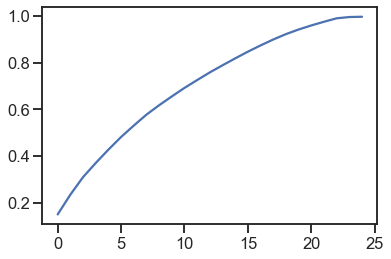

In [197]:
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(np.arange(0,25), variance[:25])

### Weather Data